# Week 1: Using CNN's with the Cats vs Dogs Dataset

Welcome to the 1st assignment of the course! This week, you will be using the famous `Cats vs Dogs` dataset to train a model that can classify images of dogs from images of cats. For this, you will create your own Convolutional Neural Network in Tensorflow and leverage Keras' image preprocessing utilities.

You will also create some helper functions to move the images around the filesystem so if you are not familiar with the `os` module be sure to take a look a the [docs](https://docs.python.org/3/library/os.html).

Let's get started!

In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

Download the dataset from its original source by running the cell below. 

Note that the `zip` file that contains the images is unzipped under the `/tmp` directory.

In [2]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take some time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-04-15 19:02:48--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.84.230.134, 2600:1407:f800:49b::e59, 2600:1407:f800:4a5::e59
Connecting to download.microsoft.com (download.microsoft.com)|184.84.230.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  97.5MB/s    in 7.4s    

2022-04-15 19:02:56 (106 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



Now the images are stored within the `/tmp/PetImages` directory. There is a subdirectory for each class, so one for dogs and one for cats.

In [3]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12501 images of dogs.
There are 12501 images of cats.


**Expected Output:**

```
There are 12501 images of dogs.
There are 12501 images of cats.
```

You will need a directory for cats-v-dogs, and subdirectories for training
and testing. These in turn will need subdirectories for 'cats' and 'dogs'. To accomplish this, complete the `create_train_test_dirs` below:

In [4]:
# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_test_dirs
def create_train_test_dirs(root_path):
  ### START CODE HERE

  # HINT:
  # Use os.makedirs to create your directories with intermediate subdirectories
  # Don't hardcode the paths. Use os.path.join to append the new directories to the root_path parameter
    
    training_dir_path = os.path.join(root_path,'training')
    testing_dir_path = os.path.join(root_path, 'testing')
    
    training_cats = os.path.join(root_path,'training/cats')
    training_dogs = os.path.join(root_path,'training/dogs')
    
    testing_cats = os.path.join(root_path,'testing/cats')
    testing_dogs = os.path.join(root_path, 'testing/dogs')
    
    os.makedirs(training_dir_path)
    os.makedirs(testing_dir_path)
    os.makedirs(training_cats)
    os.makedirs(training_dogs)
    os.makedirs(testing_cats)
    os.makedirs(testing_dogs)

  ### END CODE HERE

  
try:
    create_train_test_dirs(root_path=root_dir)
except FileExistsError:
    print("You should not be seeing this since the upper directory is removed beforehand")

In [5]:
# Test your create_train_test_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/testing
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/testing/cats
/tmp/cats-v-dogs/testing/dogs


**Expected Output (directory order might vary):**

``` txt
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/testing
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/testing/cats
/tmp/cats-v-dogs/testing/dogs

```

Code the `split_data` function which takes in the following arguments:
- SOURCE: directory containing the files

- TRAINING: directory that a portion of the files will be copied to (will be used for training)
- TESTING: directory that a portion of the files will be copied to (will be used for testing)
- SPLIT SIZE: to determine the portion

The files should be randomized, so that the training set is a random sample of the files, and the test set is made up of the remaining files.

For example, if `SOURCE` is `PetImages/Cat`, and `SPLIT` SIZE is .9 then 90% of the images in `PetImages/Cat` will be copied to the `TRAINING` dir
and 10% of the images will be copied to the `TESTING` dir.

All images should be checked before the copy, so if they have a zero file length, they will be omitted from the copying process. If this is the case then your function should print out a message such as `"filename is zero length, so ignoring."`. **You should perform this check before the split so that only non-zero images are considered when doing the actual split.**


Hints:

- `os.listdir(DIRECTORY)` returns a list with the contents of that directory.

- `os.path.getsize(PATH)` returns the size of the file

- `copyfile(source, destination)` copies a file from source to destination

- `random.sample(list, len(list))` shuffles a list

In [6]:
# GRADED FUNCTION: split_data
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

  ### START CODE HERE

    ### START CODE HERE
    all_files = []
    
    for file_name in os.listdir(SOURCE):
        file_path = os.path.join(SOURCE, file_name)
        
        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))
    
    random_training_samples = random.sample(all_files, int(len(all_files)*SPLIT_SIZE))
    
    for j in range(len(all_files)):
        
        if all_files[j] in random_training_samples:
            copyfile(SOURCE + all_files[j], TRAINING + all_files[j])
            
        else:
            copyfile(SOURCE + all_files[j], TESTING + all_files[j])

  ### END CODE HERE


In [7]:
# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
TESTING_DIR = "/tmp/cats-v-dogs/testing/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
TESTING_CATS_DIR = os.path.join(TESTING_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
TESTING_DOGS_DIR = os.path.join(TESTING_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
    for file in os.scandir(TRAINING_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
    for file in os.scandir(TRAINING_DOGS_DIR):
        os.remove(file.path)
if len(os.listdir(TESTING_CATS_DIR)) > 0:
    for file in os.scandir(TESTING_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(TESTING_DOGS_DIR)) > 0:
    for file in os.scandir(TESTING_DOGS_DIR):
        os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(TESTING_CATS_DIR))} images of cats for testing")
print(f"There are {len(os.listdir(TESTING_DOGS_DIR))} images of dogs for testing")

666.jpg is zero length, so ignoring
11702.jpg is zero length, so ignoring


There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for testing
There are 1250 images of dogs for testing


**Expected Output:**

```
666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.
```

```
There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for testing
There are 1250 images of dogs for testing
```

Now that you have successfully organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, it is time for you to code the generators that will yield batches of images, both for training and validation. For this, complete the `train_val_generators` function below.

Something important to note is that the images in this dataset come in a variety of resolutions. Luckily, the `flow_from_directory` method allows you to standarize this by defining a tuple called `target_size` that will be used to convert each image to this target resolution. **For this exercise, use a `target_size` of (150, 150)**.

**Note:** So far, you have seen the term `testing` being used a lot for referring to a subset of images within the dataset. In this exercise, all of the `testing` data is actually being used as `validation` data. This is not very important within the context of the task at hand but it is worth mentioning to avoid confusion.

In [8]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    ### START CODE HERE

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    train_datagen = ImageDataGenerator(rescale=1./255)
  
    # Pass in the appropiate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(
                                                        directory=TRAINING_DIR,
                                                        batch_size=20,
                                                        class_mode='binary',
                                                        target_size=(150, 150))

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Pass in the appropiate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(
                                                                  directory=VALIDATION_DIR,
                                                                  batch_size=20,
                                                                  class_mode='binary',
                                                                  target_size=(150, 150))
    ### END CODE HERE
    return train_generator, validation_generator


In [9]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


**Expected Output:**

```
Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
```


One last step before training is to define the architecture of the model that will be trained.

Complete the `create_model` function below which should return a Keras' `Sequential` model.

Aside from defining the architecture of the model, you should also compile it so make sure to use a `loss` function that is compatible with the `class_mode` you defined in the previous exercise, which should also be compatible with the output of your network. You can tell if they aren't compatible if you get an error during training.

**Note that you should use at least 3 convolution layers to achieve the desired performance.**

In [12]:
# GRADED FUNCTION: create_model
def create_model():
    # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
    # USE AT LEAST 3 CONVOLUTION LAYERS

    ### START CODE HERE
    model = tf.keras.models.Sequential([
                                     # Note the input shape is the desired size of the image 150x150 with 3 bytes color
                                     tf.keras.Input(shape=(150, 150, 3)),

                                     tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
                                     tf.keras.layers.MaxPooling2D(2,2),

                                     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                                     tf.keras.layers.MaxPooling2D(2,2),

                                     tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
                                     tf.keras.layers.MaxPooling2D(2,2),

                                     tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
                                     tf.keras.layers.MaxPooling2D(2,2),

                                     # Flatten the results to feed into a DNN
                                     tf.keras.layers.Flatten(),
                                     # 512 neuron hidden layer
                                     tf.keras.layers.Dense(512, activation='relu'),
                                     # Only 1 output neuron. It will contain a value from 0-1 
                                     # where 0 for 1 class ('cats') and 1 for the other ('dogs')
                                     tf.keras.layers.Dense(1, activation='sigmoid')
                                     ])
    
    model.compile(
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy']
                  )
    
    ### END CODE HERE

    return model


Now it is time to train your model!

**Note:** You can ignore the `UserWarning: Possibly corrupt EXIF data.` warnings.

In [13]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/20
 137/1125 [==>...........................] - ETA: 1:24 - loss: 0.6972 - accuracy: 0.4953

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

1125/1125 [==============================] - 96s 85ms/step - loss: 0.6902 - accuracy: 0.5232 - val_loss: 0.6761 - val_accuracy: 0.5688
Epoch 2/20
1125/1125 [==============================] - 94s 84ms/step - loss: 0.6746 - accuracy: 0.5737 - val_loss: 0.6612 - val_accuracy: 0.6080
Epoch 3/20
1125/1125 [==============================] - 95s 84ms/step - loss: 0.6340 - accuracy: 0.6417 - val_loss: 0.5557 - val_accuracy: 0.7184
Epoch 4/20
1125/1125 [==============================] - 94s 83ms/step - loss: 0.5282 - accuracy: 0.7358 - val_loss: 0.4883 - val_accuracy: 0.7716
Epoch 5/20
1125/1125 [==============================] - 94s 83ms/step - loss: 0.4586 - accuracy: 0.7815 - val_loss: 0.4332 - val_accuracy: 0.8080
Epoch 6/20
1125/1125 [==============================] - 94s 84ms/step - loss: 0.3984 - accuracy: 0.8193 - val_loss: 0.3875 - val_accuracy: 0.8308
Epoch 7/20
1125/1125 [==============================] - 94s 84ms/step - loss: 0.3502 - accuracy: 0.8425 - val_loss: 0.3856 - val_accura

Once training has finished, you can run the following cell to check the training and validation accuracy achieved at the end of each epoch.

**To pass this assignment, your model should achieve a training accuracy of at least 95% and a validation accuracy of at least 80%**. If your model didn't achieve these thresholds, try training again with a different model architecture and remember to use at least 3 convolutional layers.

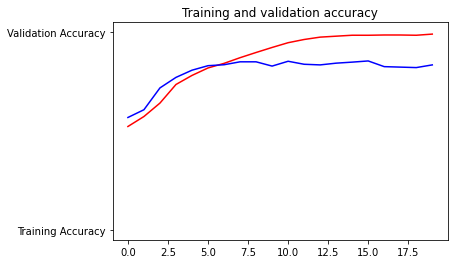

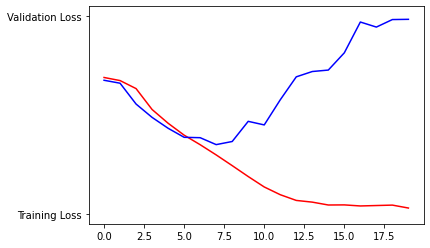

In [14]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

You will probably encounter that the model is overfitting, which means that it is doing a great job at classifying the images in the training set but struggles with new data. This is perfectly fine and you will learn how to mitigate this issue in the upcoming week.

Before downloading this notebook and closing the assignment, be sure to also download the `history.pkl` file which contains the information of the training history of your model. You can download this file by running the cell below:

In [15]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

You will also need to submit this notebook for grading. To download it, click on the `File` tab in the upper left corner of the screen then click on `Download` -> `Download .ipynb`. You can name it anything you want as long as it is a valid `.ipynb` (jupyter notebook) file.

**Congratulations on finishing this week's assignment!**

You have successfully implemented a convolutional neural network that classifies images of cats and dogs, along with the helper functions needed to pre-process the images!

**Keep it up!**